Thực hiện chiến lược DFF, sử dụng mô hình DFF.h5

Thực hiện get data thị trường chứng khoán việt nam

In [148]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
import numpy as np
import talib as ta
import pandas as pd
import yfinance as yf


# Tính toán ngày hôm trước
yesterday = datetime.now() - timedelta(1)
yesterday_str = yesterday.strftime('%Y-%m-%d')

# Tải dữ liệu giá cổ phiếu từ Yahoo Finance cho cặp tiền tệ đã chọn từ ngày hôm trước
data = yf.download('NZDCAD=X', start=yesterday_str, interval='30m')


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yfinance/scrapers/history.py:231: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  quotes2 = quotes.resample('30T')
[*********************100%%**********************]  1 of 1 completed


In [135]:
data.dropna()

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2024-05-17 00:00:00,0.83378,0.83405,0.83353,0.83389,0.83389,0
2024-05-17 00:30:00,0.83388,0.83401,0.83351,0.83370,0.83370,0
2024-05-17 01:00:00,0.83372,0.83401,0.83348,0.83389,0.83389,0
2024-05-17 01:30:00,0.83388,0.83391,0.83302,0.83317,0.83317,0
2024-05-17 02:00:00,0.83317,0.83340,0.83220,0.83253,0.83253,0
2024-05-17 02:30:00,0.83264,0.83284,0.83209,0.83259,0.83259,0
2024-05-17 03:00:00,0.83257,0.83279,0.83218,0.83254,0.83254,0
2024-05-17 03:30:00,0.83256,0.83266,0.83204,0.83259,0.83259,0
2024-05-17 04:00:00,0.83259,0.83274,0.83243,0.83259,0.83259,0


Thực hiện tính các indicator cần thiết

In [136]:
# Tải mô hình đã được lưu trước
model = load_model('dff_forex.h5')

# Tính toán các chỉ số kỹ thuật (EMA, AU, AD)
data['EMA'] = data['Close'].ewm(span=21, adjust=False).mean()
delta = data['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
data['AU'] = gain.rolling(window=14, min_periods=1).mean()
data['AD'] = loss.rolling(window=14, min_periods=1).mean()
#Tính toán thêm các indicator khác:
data['RSI'] = ta.RSI(data['Close'], timeperiod=14)
data['ERSI'] = ta.EMA(data['RSI'], timeperiod=14)

data

,Open,High,Low,Close,Adj Close,Volume,EMA,AU,AD,RSI,ERSI
Datetime,,,,,,,,,,,
2024-05-17 00:00:00,0.83378,0.83405,0.83353,0.83389,0.83389,0,0.833890,0.000000,-0.000000,NaN,NaN
2024-05-17 00:30:00,0.83388,0.83401,0.83351,0.83370,0.83370,0,0.833873,0.000000,0.000095,NaN,NaN
2024-05-17 01:00:00,0.83372,0.83401,0.83348,0.83389,0.83389,0,0.833874,0.000063,0.000063,NaN,NaN
2024-05-17 01:30:00,0.83388,0.83391,0.83302,0.83317,0.83317,0,0.833810,0.000048,0.000228,NaN,NaN
2024-05-17 02:00:00,0.83317,0.83340,0.83220,0.83253,0.83253,0,0.833694,0.000038,0.000310,NaN,NaN
2024-05-17 02:30:00,0.83264,0.83284,0.83209,0.83259,0.83259,0,0.833594,0.000042,0.000258,NaN,NaN
2024-05-17 03:00:00,0.83257,0.83279,0.83218,0.83254,0.83254,0,0.833498,0.000036,0.000229,NaN,NaN
2024-05-17 03:30:00,0.83256,0.83266,0.83204,0.83259,0.83259,0,0.833415,0.000037,0.000200,NaN,NaN
2024-05-17 04:00:00,0.83259,0.83274,0.83243,0.83259,0.83259,0,0.833340,0.000033,0.000178,NaN,NaN


Thực hiện thêm mô hình

In [137]:
# Chuẩn hóa dữ liệu
scaler = StandardScaler()
features = ['EMA', 'AU', 'AD']
X = scaler.fit_transform(data[features])

# Dự đoán trạng thái thị trường
predicted_classes = np.argmax(model.predict(X), axis=1)

# Chuyển đổi trạng thái thị trường thành các label tương ứng
market_states = ['Downtrend', 'Uptrend', 'Sideway']
predicted_labels = [market_states[i] for i in predicted_classes]

data['Market_State'] = predicted_labels

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Kiểm  tra thử trạng thái thị trường

In [138]:
for i, (index, row) in enumerate(data.iterrows()):
    # In ra trạng thái thị trường và ngày tương ứng
    print(f"Date: {index}, Market State: {predicted_labels[i]}")

Date: 2024-05-17 00:00:00, Market State: Uptrend
Date: 2024-05-17 00:30:00, Market State: Downtrend
Date: 2024-05-17 01:00:00, Market State: Uptrend
Date: 2024-05-17 01:30:00, Market State: Uptrend
Date: 2024-05-17 02:00:00, Market State: Downtrend
Date: 2024-05-17 02:30:00, Market State: Downtrend
Date: 2024-05-17 03:00:00, Market State: Downtrend
Date: 2024-05-17 03:30:00, Market State: Uptrend
Date: 2024-05-17 04:00:00, Market State: Uptrend


Thực hiện kiểm tra điều kiện vào lệnh, tính toán các indicator thêm:

In [139]:


data.dropna()

,Open,High,Low,Close,Adj Close,Volume,EMA,AU,AD,RSI,ERSI,Market_State
Datetime,,,,,,,,,,,,


In [140]:
# Đặt lại tên chỉ mục
data.index.name = 'Date'

# Chuyển đổi chỉ mục từ text sang datetime
data.index = pd.to_datetime(data.index, format='%Y-%m-%d')

# Lấy năm và tháng hiện tại
current_year = pd.Timestamp.now().year
current_month = pd.Timestamp.now().month

# Lọc dữ liệu của tháng hiện tại
data_current_month = data[(data.index.year == current_year) & (data.index.month == current_month)]

# Loại bỏ các dòng có giá trị NaN
data_current_month = data_current_month.dropna()

# In toàn bộ dữ liệu của tháng hiện tại
print(data_current_month)

Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume, EMA, AU, AD, RSI, ERSI, Market_State]
Index: []


Thực hiện kiểm tra điều kiện hiện tại:

In [141]:
# print(data.last)

last_row = data.iloc[-1]
if(
    (last_row['RSI'] > last_row['ERSI'])
    and (last_row['Market_State'] == 'Uptrend')
    and (last_row['ERSI'] > 40 or last_row['ERSI'] < 60)
):
    print('buy')
else: print('Not buy this time')
last_row

def condition_buy(rsi, ersi, market_state):
    if ((rsi > ersi)
    and (market_state == 'Uptrend')
    and (ersi > 40 or ersi < 60)):
        return True
    else: return False

def condition_sell(rsi, ersi, market_state):
    if ((rsi< ersi)
    and (market_state == 'Downtrend')
    and (ersi > 40 or ersi < 60)):
        return True
    else: return False

Not buy this time


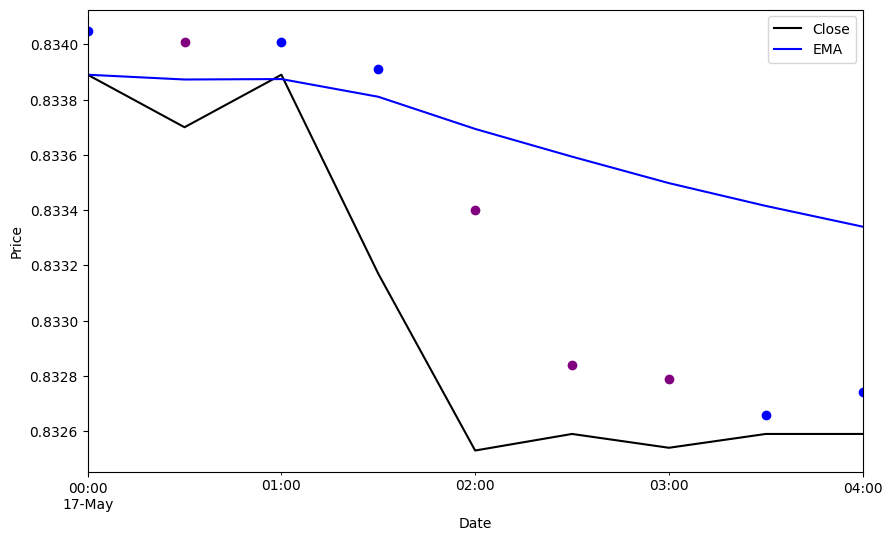

In [142]:
import pandas as pd
import mplfinance as mpf
import matplotlib.pyplot as plt

# Lọc dữ liệu từ năm
filtered_data = data.loc['2023-05-15':]
filtered_data

# Lấy giá trị của trạng thái thị trường
market_states = filtered_data[["RSI", "ERSI", "Market_State"]]
# Tạo một biến để lưu trữ trạng thái hiện tại của thị trường
current_market_state = None

# Vẽ biểu đồ nến
filtered_data['Close'].plot(figsize=(10, 6), color='black')
filtered_data['EMA'].plot(figsize=(10, 6), color='blue')

for index, row in market_states.iterrows():
    rsi = row['RSI']
    ersi = row['ERSI']
    market_state = row['Market_State']
    if market_state != current_market_state:
        current_market_state = market_state
        if(condition_buy(rsi , ersi, market_state) ):
            color = 'green'
            plt.scatter(index, filtered_data.loc[index, 'Low'], color=color, marker='o')
        if(condition_sell(rsi , ersi, market_state) ):
            color = 'red'
            plt.scatter(index, filtered_data.loc[index, 'Low'], color=color, marker='o')

for index, row in market_states.iterrows():
    market_state = row['Market_State']
    current_market_state = market_state
    if(market_state == "Uptrend"): color = 'blue' 
    else: color = 'purple'
    
    plt.scatter(index, filtered_data.loc[index, 'High'], color=color, marker='o')

# Đặt tiêu đề và nhãn trục
plt.xlabel('Date')
plt.ylabel('Price')

# Hiển thị chú thích
plt.legend()

# Hiển thị biểu đồ
plt.show()